<a href="https://colab.research.google.com/github/elenagonzalezrebollo/AlgoritmoGenetico/blob/main/Regresion_Prediccion_Combustible.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Prediciendo precios de casas: Un ejemplo de regresion
----
La **"regresión"**, consiste en **predecir** un **valor continuo** de una etiqueta discreta. Por ejemplo, predecir la temperatura de mañana, dados los datos meteorológicos, o predecir el tiempo en que un proyecto de software tardará en completarse, dadas sus especificaciones.

**No confundir "regresión" con el algoritmo "regresión logística"**: confusamente, "regresión logística" no es un algoritmo de regresión, es un **algoritmo de clasificación**.

## El conjunto de datos de Precios de Casas de Boston

Vamos a **predecir** el **precio medio** de las **viviendas** en un suburbio determinado de **Boston** a mediados de la década de 1970, dados algunos puntos de datos sobre el suburbio en ese momento, como la **tasa de criminalidad**, la **tasa de impuesto a la propiedad local**, etc.

El conjunto de datos que usaremos tiene otra diferencia interesante con nuestros dos ejemplos anteriores: **tiene muy pocos puntos de datos**, solo 506 en total, dividido entre 404 muestras de entrenamiento y 102 muestras de prueba, y **cada "característica"** en los datos de entrada (por ejemplo, la tasa de criminalidad) es una característica que tiene una **escala diferente**. Por ejemplo, algunos valores son proporciones, que toman valores entre 0 y 1, otros toman valores entre 1 y 12, otros entre 0 y 100 ... 

In [ ]:
from keras.datasets import boston_housing

data = pd.read_csv('auto-mpg.csv', encoding='latin-1')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [ ]:
data.shape

(398, 9)

In [ ]:
data=data.drop(['car name','horsepower'], axis=1)

In [ ]:
train_targets=data.mpg[:298]
test_targets=data.mpg[299:]
data=data.drop(['mpg'], axis=1)
train_data=data[:298]
test_data=data[299:]

In [ ]:
train_data.shape

(298, 7)

In [ ]:
train_targets.shape

(298,)

In [ ]:
test_data.shape

(99, 7)

In [ ]:
test_targets.shape

(99,)

In [ ]:
# Las 13 características de la primera casa en el set de entrenamiento
train_data[:1]

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,8,307.0,130,3504,12.0,70,1


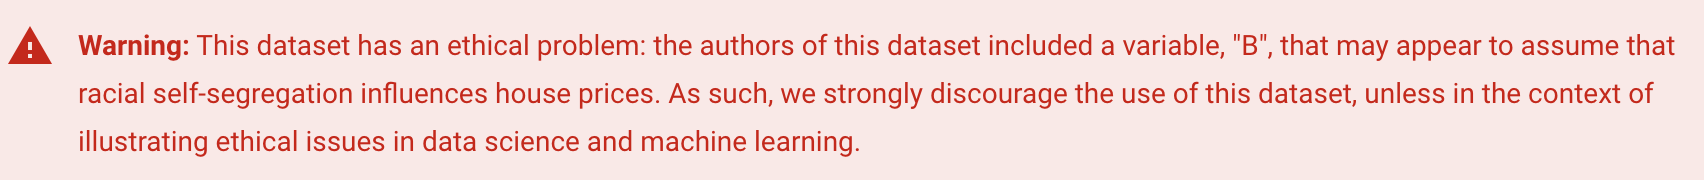

Tenemos 404 muestras de entrenamiento y 102 muestras de prueba. Los datos comprenden 13 características:

1. **Tasa de delincuencia** per cápita.
2. **Proporción de terreno residencial** dividido en zonas para lotes de más de 25k pies cuadrados.
3. **Proporción de acres comerciales no minoristas** por municipio.
4. **Variable ficticia de Charles River** (= 1 si el tramo limita con el río; 0 en caso contrario).
5. Concentración de **óxidos nítricos** (partes por 10 millones).
6. **Número medio de habitaciones por vivienda**.
7. **Proporción de casas/pisos ocupados por sus propietarios** construidas antes de 1940.
8. **Distancias ponderadas a cinco centros de empleo** de Boston.
9. **Índice de accesibilidad a carreteras** radiales.
10. **Tasa de impuesto a la propiedad** de valor total por 10K dólares.
11. P**roporción alumnos por profesor** por municipio.
12. **1000*(Bk-0,63)^2** donde **Bk** es la **proporción** de **personas de color** por municipio.
13. **% bajo estatus** de la población.

Los objetivos (**etiquetas**) son los **valores medios de las viviendas** ocupadas por sus propietarios, en miles de dólares:

In [ ]:
# Los 102 precios medios de los datos de test en miles de $
test_targets

299    27.2
300    23.9
301    34.2
302    34.5
303    31.8
       ... 
393    27.0
394    44.0
395    32.0
396    28.0
397    31.0
Name: mpg, Length: 99, dtype: float64

Los precios suelen oscilar entre 10K dólares y 50K dólares. Recordar que esto fue a mediados de la década de 1970, y estos precios no se han ajustado por la inflación.

## Preparando los datos

* **Problemático alimentar a una red neuronal con valores que toman rangos tremendamente diferentes** (la **red podría adaptarse automáticamente a datos tan heterogéneos, pero dificultaría el aprendizaje**)
* Cuando pase esto debemos hacer una **normalización en relación a las características**: para cada característica en los datos de entrada (una columna en la matriz de datos de entrada), **restamos la media de la característica** y la **dividiremos por la desviación estándar**, de modo que **la característica se centrará alrededor de 0** y tendrá una **desviación estándar unitaria**. Esto se hace fácilmente en Numpy:

In [ ]:
# Normalizamos basándonos en la característica
##############################################
# Calculamos la media del primer eje de los datos de entrenamiento
mean = train_data.mean(axis=0)
print("##### Media de las 13 características de los datos de entrenamiento ##### ")
print(mean)
# A los datos de entrenamiento le restamos la media
train_data -= mean

# Calculamos la desviación estandar del primer eje de los datos de entrenamiento
std = train_data.std(axis=0)
print("##### Desviación estandar de las 13 características de los datos de entrenamiento ##### ")
print(std)
# A los datos de entrenamiento los dividimos por la desviación estándar
train_data /= std
print("##### Datos de entrenamiento normalizados para la primera casa ##### ")
print(train_data[1:])

# ¡¡IMPORTANTE!!: USAMOS LA MEDIA Y LA DESVIACIÓN ESTANDAR DE LOS DATOS DE 
# ENTRENAMIENTO PARA NORMALIZAR EL SET DE DATOS DE LOS DATOS DE TEST 
test_data -= mean
test_data /= std
print("##### Datos de test normalizados (de la primera casa) con la media y la desviación estándar de los datos de entrenamiento ##### ")
print(test_data[1:])

##### Media de las 13 características de los datos de entrenamiento ##### 
cylinders          5.808725
displacement     214.498322
weight          3130.234899
acceleration      15.223154
model year        74.402685
origin             1.473154
dtype: float64
##### Desviación estandar de las 13 características de los datos de entrenamiento ##### 
cylinders         1.750514
displacement    109.088159
horsepower             NaN
weight          886.309770
acceleration      2.691119
model year        2.760763
origin            0.739199
dtype: float64
##### Datos de entrenamiento normalizados para la primera casa ##### 
     cylinders  displacement horsepower    weight  acceleration  model year  \
1     1.251789      1.242130        NaN  0.634953     -1.383497   -1.594735   
2     1.251789      0.948789        NaN  0.344987     -1.569293   -1.594735   
3     1.251789      0.820453        NaN  0.341602     -1.197700   -1.594735   
4     1.251789      0.802119        NaN  0.359654     -1.755089

<ipython-input-222-1f50c9d80af0>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = train_data.mean(axis=0)


In [ ]:
train_data.shape[1:]

(7,)

* Tener en cuenta que las **cantidades** que utilizamos **para normalizar los datos de prueba** se han calculado **utilizando los datos de entrenamiento**. 
* **Nunca debemos usar** en nuestro flujo de trabajo cualquier **cantidad calculada en los datos de prueba**, **incluso para** algo tan simple como **la normalización de datos**.

## Construyendo la red

Debido a que hay tan **pocas muestras disponibles**, usaremos una **red muy pequeña** con **dos capas ocultas**, cada una con 64 unidades. En general, **cuantos menos datos de entrenamiento tengamos, peor será el sobreajuste y el uso una red pequeña es una forma de reducir el sobreajuste**.

In [ ]:
import tensorflow as tf
from keras import models
from keras import layers

def build_model():
    # Porque necesitaremos instanciar el mismo modelo 
    # múltiples veces, usamos una función para construirlo
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # MSE: Mean Squared Error
    # MAE: Mean Absolute Error
    model.compile(optimizer='rmsprop', loss='mse', 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()]) # metrics = ['mae']
    return model

* Nuestra red **termina** con **una sola unidad** y **sin activación** (es decir, **será una capa lineal**).
* **Configuración típica para la regresión escalar** (es decir, **regresión en la que intentamos predecir un único valor continuo**).
  - La aplicación de una **función de activación** **limitaría el rango que puede tomar la salida**; por ejemplo si aplicamos una función de activación "sigmoide" a nuestra última capa, la red solo aprendería a predecir valores entre 0 y 1. 
  - Aquí, porque la última capa es puramente lineal, **la red es libre de aprender a predecir valores en cualquier rango**.
* Compilamos la red con la función de pérdida `mse` (**error cuadrático medio**, el cuadrado de la diferencia entre predicciones y los objetivos, una **función de pérdida ampliamente utilizada para problemas de regresión**)
* Estamos **monitorizando una nueva métrica durante el entrenamiento**: `mae` **error absoluto medio** (valor absoluto de la diferencia entre las predicciones y los objetivos). Por ejemplo, **un MAE de 0.5 en este problema significaría que nuestras predicciones están equivocadas por 500 dólares en promedio**.

## Ejercício: Con estos datos, computar el problema con las primeras 3/4 partes de los datos de entrenamiento para entrenar y el último 1/4 de los datos para validación

In [ ]:
# 1. Hacer aquí las particiones de los datos de entrenamiento
partial_train_data = train_data[:223]   #.values.tolist()
partial_eval_train_data = train_data[224:]
partial_train_targets = train_targets[:223]
partial_eval_train_targets = train_targets[224:]

In [ ]:
partial_train_data = tf.convert_to_tensor(partial_train_data,dtype = tf.int64 )

ValueError: ignored

In [ ]:
partial_train_data.shape

(223, 7)

In [ ]:
partial_eval_train_data.shape

In [ ]:
partial_train_targets.shape

In [ ]:
partial_eval_train_targets.shape

In [ ]:
type(partial_train_data)

list

In [ ]:
# 2. Entrenar el modelo con 100 épocas y un batch_size=1
mymodel = build_model()

In [ ]:
history = mymodel.fit(partial_train_data, partial_train_targets,
            validation_data=(partial_eval_train_data, partial_eval_train_targets),
                        epochs=100, batch_size=1)

Epoch 1/100
223/223 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
223/223 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/100
223/223 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/100
223/223 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan


KeyboardInterrupt: ignored

In [ ]:
mae_history = history.history['val_mean_absolute_error']

In [ ]:
mse_history = history.history['val_loss']

In [ ]:
# 3. Confrontar en una gráfica de épocas en el eje de abcisas contra pérdida (MSE) en
# el eje de ordenadas
import matplotlib.pyplot as plt

plt.plot(range(1, len(mse_history) + 1), mse_history)
plt.xlabel('Epochs')
plt.ylabel('Validación MSE')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Pérdida del entreno')
plt.plot(epochs, val_loss, 'b', label='Pérdida de la validación')
plt.title('Perdidas del entreno y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [ ]:
# 4. Confrontar en una gráfica de épocas en el eje de abcisas contra la métrica de 
# error absoluto medio (MAE) 
import matplotlib.pyplot as plt

plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Pérdida del entreno')
plt.plot(epochs, val_loss, 'b', label='Pérdida de la validación')
plt.title('Perdidas del entreno y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [ ]:
# 5. Entrenar de nuevo el modelo el número de épocas adecuado para evitar overfitting
mymodel2 = build_model()
history2 = mymodel2.fit(partial_train_data, partial_train_targets,
            validation_data=(partial_eval_train_data, partial_eval_train_targets),
                        epochs=20, batch_size=1)

In [ ]:
mae_history2 = history2.history['val_mean_absolute_error']
mse_history2 = history2.history['val_loss']

import matplotlib.pyplot as plt

plt.plot(range(1, len(mse_history2) + 1), mse_history2)
plt.xlabel('Epochs')
plt.ylabel('Validación MSE')
plt.show()

import matplotlib.pyplot as plt

plt.plot(range(1, len(mae_history2) + 1), mae_history2)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()

## Validando nuestro enfoque usando la **validación K-fold o K-iteraciones**

* Para evaluar nuestra red mientras seguimos ajustando sus parámetros en pleno entrenamiento(número de épocas o iteraciones), **podríamos dividir** los datos en un conjunto de **entrenamiento** y un conjunto de **validación**.
* Como tenemos tan **pocos datos**, conjunto de validación sería muy pequeño
  - Consecuencia: nuestras **puntuaciones de validación** pueden **cambiar mucho dependiendo de los puntos de datos que elijamos** usar para la validación y cuales elijamos para el  entrenamiento (**las puntuaciones de validación podrían tener alta varianza con respecto a la división de validación**). Esto **impide una evaluación fiable del modelo**.
* En estos casos utilizamos la **validación cruzada de K-fold (k-iteraciones)**:
  - Consiste en **dividir los datos disponibles en K particiones** (típicamente **K = 4** o **5**)
  - Luego utilizando **instancias de K modelos idénticos** y entrenando cada uno en K-1 particiones mientras se evalúa la partición restante. 
* La puntuación de la validación para el modelo utilizado sería entonces el **promedio de las puntuaciones de las K validaciones obtenidas**.

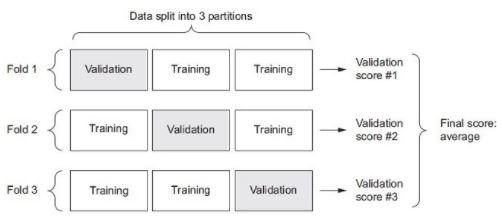

En términos de código, esto es sencillo:

In [ ]:
import numpy as np

# k= 4 particiones
k = 4
num_val_samples = len(train_data) // k # 404//4=101
print("num_val_samples", num_val_samples)
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Preparamos la validación de los datos: datos de la partición #k
    print("Uso para validar el siguiente rango de datos de entrenamiento -> [",(i * num_val_samples),":",((i + 1) * num_val_samples),"]")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Preparamos los datos de entrenamiento: Datos de las demás particiones
    print("Uso para entrenar el siguiente rango de datos de entrenamiento -> [0:",(i * num_val_samples),"]U[",(i + 1) * num_val_samples,":",len(train_data),"]")
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construcción del modelo Keras (ya compilado)
    model = build_model()
    # Entrenando el modelo (en modo silencioso, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evalua el modelo sobre los datos de validación
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [ ]:
all_scores

In [ ]:
np.mean(all_scores)

* Se puede ver que diferentes ejecuciones muestran puntuajes de validación bastante diferentes, de 1.9 a 2.9 
* El **promedio** (2.49) **es una métrica mucho más confiable que cualquier puntuación individual**; **esa es la clave de la validación cruzada de K-iteraciones**.
* En este caso, **nos desviamos una media de 2.500 dólares, significativo** considerando que los precios oscilan entre 10K dólares (25%) y 50K dólares (5%).

Vamos a entrenar la red un poco más de tiempo: **500 repeticiones**. Para mantener un registro de cómo de bien funciona el modelo en cada repetición, **modificaremos nuestro ciclo de entrenamiento para guardar el registro de puntuación de validación por repetición**:

In [ ]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Preparamos la validación de los datos: datos de la partición # k
    print("Uso para validar el siguiente rango de datos de entrenamiento -> [",(i * num_val_samples),":",((i + 1) * num_val_samples),"]")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Preparamos los datos de entrenamiento: Datos de todas la demás particiones
    print("Uso para entrenar el siguiente rango de datos de entrenamiento -> [0:",(i * num_val_samples),"]U[",(i + 1) * num_val_samples,":",len(train_data),"]")
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construcción del modelo Keras (ya compilado)
    model = build_model()
    # Entrenando el modelo (en modo silencioso, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

A continuación, podemos **calcular el promedio de las puntuaciones MAE por repetición para todas los iteraciones**:

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Lo pintamos:

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()

Puede ser un poco difícil ver el gráfico debido a **problemas de escala** y la **varianza relativamente alta**. Vamos a:

* **Omitir los primeros 10 puntos de datos**, que están en una **escala diferente del resto de la curva**.
* Reemplazar cada punto con una **media móvil exponencial** de los puntos anteriores para obtener una curva suave.(Una promedio móvil exponencial (**EMA**) es un cálculo del **valor medio durante un período de tiempo específico** que **da más peso a los datos de valores más recientes**, lo que hace que **reaccione más rápidamente a los cambios de valores**. Se utilizan en bolsa en los gráficos para ayudar a determinar la **tendencia**, la **dirección** y la **fuerza** de los precios de un valor) (EMA(actual) = ((Precio(actual) – EMA (anterior)) x Multiplicador) + EMA(anterior))

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Repeticiones')
plt.ylabel('MAE de validación')
plt.show()

Según este gráfico, parece que el **MAE de validación deja de mejorar significativamente después de 80 repeticiones**. Pasado ese punto, comenzamos a sobreajustar.

Una vez que hayamos terminado de ajustar otros parámetros de nuestro modelo (además del número de repeticiones, también podríamos ajustar el tamaño de las capas ocultas), podemos **entrenar un modelo de "producción" final** en todos los datos de entrenamiento, **con los mejores parámetros**, y luego observar su rendimiento en los datos de prueba:

In [ ]:
# Obtenemos un modelo compilado nuevo
model = build_model()
# Lo entrenamos en todos los datos.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score

Todavía estamos desviados en alrededor de 2.772 dólares

## Resumiendo

Esto es lo que se debería sacar de este ejemplo:

* La **regresión se realiza utilizando funciones de pérdida diferentes a las usadas en la clasificación**; El **error cuadrático medio (MSE)** es una **función de pérdida de uso común para regresión**.
* De manera similar, **las métricas de evaluación que se utilizarán para la regresión difieren de las utilizadas para la clasificación**; naturalmente, **el concepto de "precisión" o exactitud no aplica para regresión**. **Una métrica de regresión común es el error absoluto medio (MAE)**.
* Cuando las características en los datos de entrada tienen **valores en diferentes rangos**, **cada característica debe escalarse de forma independiente** como paso de preprocesamiento.
* Cuando hay **pocos datos disponibles**, usar la **validación de K-iteraciones** es una excelente manera de evaluar un modelo de manera fiable.
* Cuando hay **pocos datos de entrenamiento** disponibles, es preferible **usar una red pequeña con muy pocas capas ocultas** (**generalmente solo una o dos**), para **evitar un sobreajuste** exagerado.

---